# Newton 1st Law

### **Introduction**

Newton's First Law of Motion, often referred to as the Law of Inertia, is one of the fundamental principles in classical mechanics. It states that:
_"An object at rest will stay at rest, and an object in motion will continue moving with the same speed and in the same direction, unless acted upon by an unbalanced external force."_

In simpler terms, this law explains that things tend to keep doing what they’re already doing, whether that’s staying still or moving in a straight line, unless something interferes with them.


### **What is it?**

Newton’s First Law essentially describes the natural state of motion of an object. If no forces are acting on an object, it will maintain its state of motion—either staying still or moving at a constant speed in a straight line. This tendency of objects to resist changes in their motion is called inertia. The law highlights the importance of forces in changing an object's motion. Without any external force (like a push, pull, or gravity), an object won't speed up, slow down, or change direction.


### **Example**

A common example of Newton’s First Law is when you're riding in a car that suddenly brakes. When the car slows down, your body tends to keep moving forward. This happens because your body wants to stay in motion (thanks to inertia), while the car has stopped. In this case, the seatbelt is the external force that acts on your body to bring it to a stop along with the car.

Another everyday example is a book resting on a table. The book will remain at rest until a force (such as a push) is applied to move it. Without that push, the book won’t spontaneously start moving on its own—indicating that objects have a natural tendency to resist changes in their state of motion. Newton’s First Law helps us understand the basic behavior of objects in motion or at rest, and is crucial in explaining how forces and motion interact in the physical world.


# Simulation

### Installing packages (for Google Colab)

If this notebook is opened in Google Colab then some packages must be installed to run the code!

In [1]:
#@title Run to install MuJoCo and `dm_control` for Google Colab

IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
    import distutils.util
    import os
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
            "file_format_version" : "1.0.0",
            "ICD" : {
                "library_path" : "libEGL_nvidia.so.0"
            }
        }
        """)

    print('Installing dm_control...')
    !pip install -q dm_control>=1.0.22

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl 

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    !echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

    # Graphics and plotting.
    print('Installing mediapy:')
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
    !pip install -q mediapy

    !git clone https://github.com/commanderxa/extraphi.git

## Import

Import all required packages to preform simulations. Packages include simulation engine, plotting libraries and other ones necessary for computations.

In [2]:
%env MUJOCO_GL=egl

import os

# simulation
from dm_control import mjcf

# for video recording
import mediapy

# computations
import numpy as np

# plot charts
import seaborn as sns
import matplotlib.pyplot as plt

env: MUJOCO_GL=egl


In [3]:
sns.set_theme(style="whitegrid")

## Initial Conditions

In this block constants are defined. They impact the environment, rendering and objects directly.

In [4]:
# global
viscosity = 0.00000  # Air Resistance

# simulation constants
mass = 0.5  # mass [kg]
a = 2  # acceleration [m/s^2]
barrier_pos = 20 # [m]
distance = 100

# rendering
width = 1280
height = 720
dpi = 600
duration = 10  # (seconds)
framerate = 60  # (Hz)

# project related
unit = os.getcwd().split("/")[-1]  # get the current directory
section = os.getcwd().split("/")[-2]  # get the current directory

## Model

### Scene

Import scene from `mechanics/scene.py`. The code is a bit difficult due to the import from parent directories.

In [5]:
import os, sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from scene import Scene

### Objects of Interest

Here we create all the objects that will interact in the world. To model `inertia` one might create a car and a barrier into which car will crash. On that car there might be a sphere which will start continuing it's trajectory after the crash.

In [6]:
class Sphere(object):

    def __init__(self, size: float, mass: float, camera: bool = True) -> None:
        self.model = mjcf.RootElement(model="sphere")
        self.sphere = self.model.worldbody.add("body", name="sphere", pos=[0, 0, 0])
        self.sphere_geom = self.sphere.add(
            "geom",
            name="sphere_geom",
            type="sphere",
            size=[size],
            rgba=[1, 0, 0, 1],
            mass=mass,
            condim=1,
        )

        self.move = self.sphere.add("joint", name="move", type="slide", axis=[1, 0, 0])
        self.fall = self.sphere.add("joint", name="fall", type="slide", axis=[0, 0, 1])

        if camera:
            self.camera = self.sphere.add(
                "camera",
                name="front",
                pos=[0, -2, 0],
                euler=[90, 0, 0],
                mode="track",
            )


class Box(object):

    def __init__(
        self, name: str, size: list[float], rgba: list[float] = [0.1, 0.1, 0.5, 1]
    ) -> None:
        self.model = mjcf.RootElement(model=name)
        self.box = self.model.worldbody.add("body", name="box", pos=[0, 0, 0])
        self.box_geom = self.box.add(
            "geom",
            name="box_geom",
            type="box",
            size=size,
            rgba=rgba,
            condim=1,
        )


class Wheel(object):

    def __init__(self, id: int) -> None:
        self.model = mjcf.RootElement(model=f"wheel_{id}")
        self.wheel = self.model.worldbody.add("body", name="wheel")
        self.wheel_geom = self.wheel.add(
            "geom",
            name="wheel_geom",
            type="cylinder",
            size=[0.1, 0.01],
            pos=[0, 0, 0],
            euler=[90, 0, 0],
        )
        self.joint = self.wheel.add("joint", name=f"move", type="hinge", axis=[0, 1, 0])
        self.motor = self.model.actuator.add("motor", name="motor", joint=self.joint)


class Cart(object):

    def __init__(self, height: float, sphere_size: float) -> None:
        self.model = mjcf.RootElement(model="cart")

        self.cart = self.model.worldbody.add("body", name="cart", pos=[0, 0, 0])

        self.cart_geom = Box(
            name="cart_base", size=[sphere_size + sphere_size / 2, sphere_size, height]
        )
        self.cart_site = self.cart.add("site", pos=[0, 0, 0])
        self.cart_site.attach(self.cart_geom.model)

        self.cart_holder = self.cart.add(
            "geom",
            name="cart_support",
            type="box",
            size=[sphere_size / 2, sphere_size, height],
            euler=[0, 90, 0],
            rgba=[0.1, 0.1, 0.5, 1],
            pos=[-(sphere_size + sphere_size / 2), 0, sphere_size * 0.5],
        )

        self.wheel_pos = [
            [-sphere_size, -sphere_size, 0],
            [sphere_size, sphere_size, 0],
            [-sphere_size, sphere_size, 0],
            [sphere_size, -sphere_size, 0],
        ]

        for i, wheel_pos in enumerate(self.wheel_pos):
            wheel = Wheel(id=i)
            wheel_site = self.cart.add("site", pos=wheel_pos)
            wheel_site.attach(wheel.model)

        self.move = self.cart.add("joint", name="move", type="slide", axis=[1, 0, 0])
        self.fall = self.cart.add("joint", name="fall", type="slide", axis=[0, 0, 1])

### World Model

Collecting everything into one general model

In [7]:
class Model(object):

    def __init__(self, distance: float) -> None:
        self.model = mjcf.RootElement(model="model")

        # set render info
        self.model.visual.__getattr__("global").offheight = height
        self.model.visual.__getattr__("global").offwidth = width

        # set the simulation constants
        self.model.option.viscosity = viscosity

        # create the scene (ground)
        self.scene = Scene(length=distance, width=4)
        self.scene_site = self.model.worldbody.add("site", pos=[distance / 2, 0, 0])
        self.scene_site.attach(self.scene.model)

        self.sphere_size = 0.2

        # add cart
        self.cart = Cart(height=0.05, sphere_size=self.sphere_size)
        cart_site = self.model.worldbody.add(
            "site", pos=[self.sphere_size * 2, 0, self.sphere_size / 2]
        )
        cart_site.attach(self.cart.model)

        # add sphere
        self.sphere = Sphere(size=self.sphere_size, mass=mass)
        sphere_site = self.model.worldbody.add(
            "site", pos=[self.sphere_size * 2, 0, self.sphere_size * 2]
        )
        sphere_site.attach(self.sphere.model)

        # add barrier
        barrier_height = (0.1 + self.sphere_size) / 4
        self.barrier = Box(
            name="barrier",
            size=[(distance / 2 - barrier_pos), self.sphere_size, barrier_height],
            rgba=[0.4, 0.2, 0.1, 1]
        )
        barrier_site = self.model.worldbody.add(
            "site", pos=[distance / 2 + barrier_pos, 0, barrier_height]
        )
        barrier_site.attach(self.barrier.model)

        # add block
        self.block = Box(name="block", size=[1, 1, 1])
        block_site = self.model.worldbody.add(
            "site", pos=[distance, 0, 1], euler=[0, 0, 90]
        )
        block_site.attach(self.block.model)

## Simulation

Initializing the `physics` of the simulation

In [8]:
model = Model(distance).model
physics = mjcf.Physics.from_mjcf_model(model)

First of all, the environment must be verified by rendering a picture

""

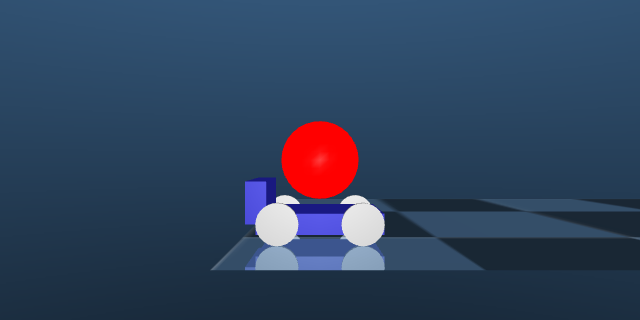

In [10]:
mediapy.show_image(physics.render(height=320, width=640, camera_id=0))

Previously, we added a motor for each wheel, and that's how we can access them:

In [11]:
physics.named.data.ctrl

FieldIndexer(ctrl):
0 cart/wheel_0/motor [ 0       ]
1 cart/wheel_1/motor [ 0       ]
2 cart/wheel_2/motor [ 0       ]
3 cart/wheel_3/motor [ 0       ]

Get IDs of interesting objects

In [12]:
cart_base_id = physics.model.name2id("cart/cart_base/box_geom", "geom")
sphere_id = physics.model.name2id("sphere/sphere_geom", "geom")
barrier_id = physics.model.name2id("barrier/box_geom", "geom")
block_id = physics.model.name2id("block/box_geom", "geom")
cart_base_id, sphere_id, barrier_id, block_id

(2, 7, 8, 9)

### Simulation Loop

In [13]:
frames = []
timevals = []
velocity = []
position = []

impact_time_index = None
ball_stop_time_index = None

while physics.data.time < duration:
    physics.step()  

    if impact_time_index is None:
        # physics.bind(model.find_all("actuator")).ctrl += a * physics.model.opt.timestep
        physics.named.data.qvel["cart/move"] = 15
        physics.named.data.qvel["sphere/move"] = 15
    else:
        physics.bind(model.find_all("actuator")).ctrl = 0
        physics.named.data.qvel["cart/move"] = 0
        physics.named.data.qvel["cart/fall"] = 0
        
    for i, c in enumerate(physics.data.contact):
        # get time when the car hit the barrier
        if cart_base_id in c.geom and barrier_id in c.geom and impact_time_index is None:
            impact_time_index = len(timevals)
        # get the time to stop the simulation
        if sphere_id in c.geom and block_id in c.geom and ball_stop_time_index is None:
            ball_stop_time_index = len(timevals)

    timevals.append(physics.data.time)
    velocity.append(physics.named.data.qvel["sphere/move"][0].copy())
    position.append(physics.named.data.geom_xpos["sphere/sphere_geom"][0].copy())

    if len(frames) < physics.data.time * framerate:
        pixels = physics.render(width=width, height=height, camera_id=0)
        frames.append(pixels)

In [14]:
mediapy.show_video(frames, fps=framerate)

In [15]:
mediapy.write_video(f"../../output/newton_law_1.mp4", images=frames, fps=framerate)

## Simulation Data Visualization

Convert data into numpy array to have more features

In [16]:
velocity = np.array(velocity)
position = np.array(position)

In [17]:
velocity_before = velocity[:impact_time_index]
timevals_before = timevals[:impact_time_index]

velocity_after = velocity[impact_time_index:ball_stop_time_index]
timevals_after = timevals[impact_time_index:ball_stop_time_index]

position = position[:ball_stop_time_index]
timevals_p = timevals[:ball_stop_time_index]

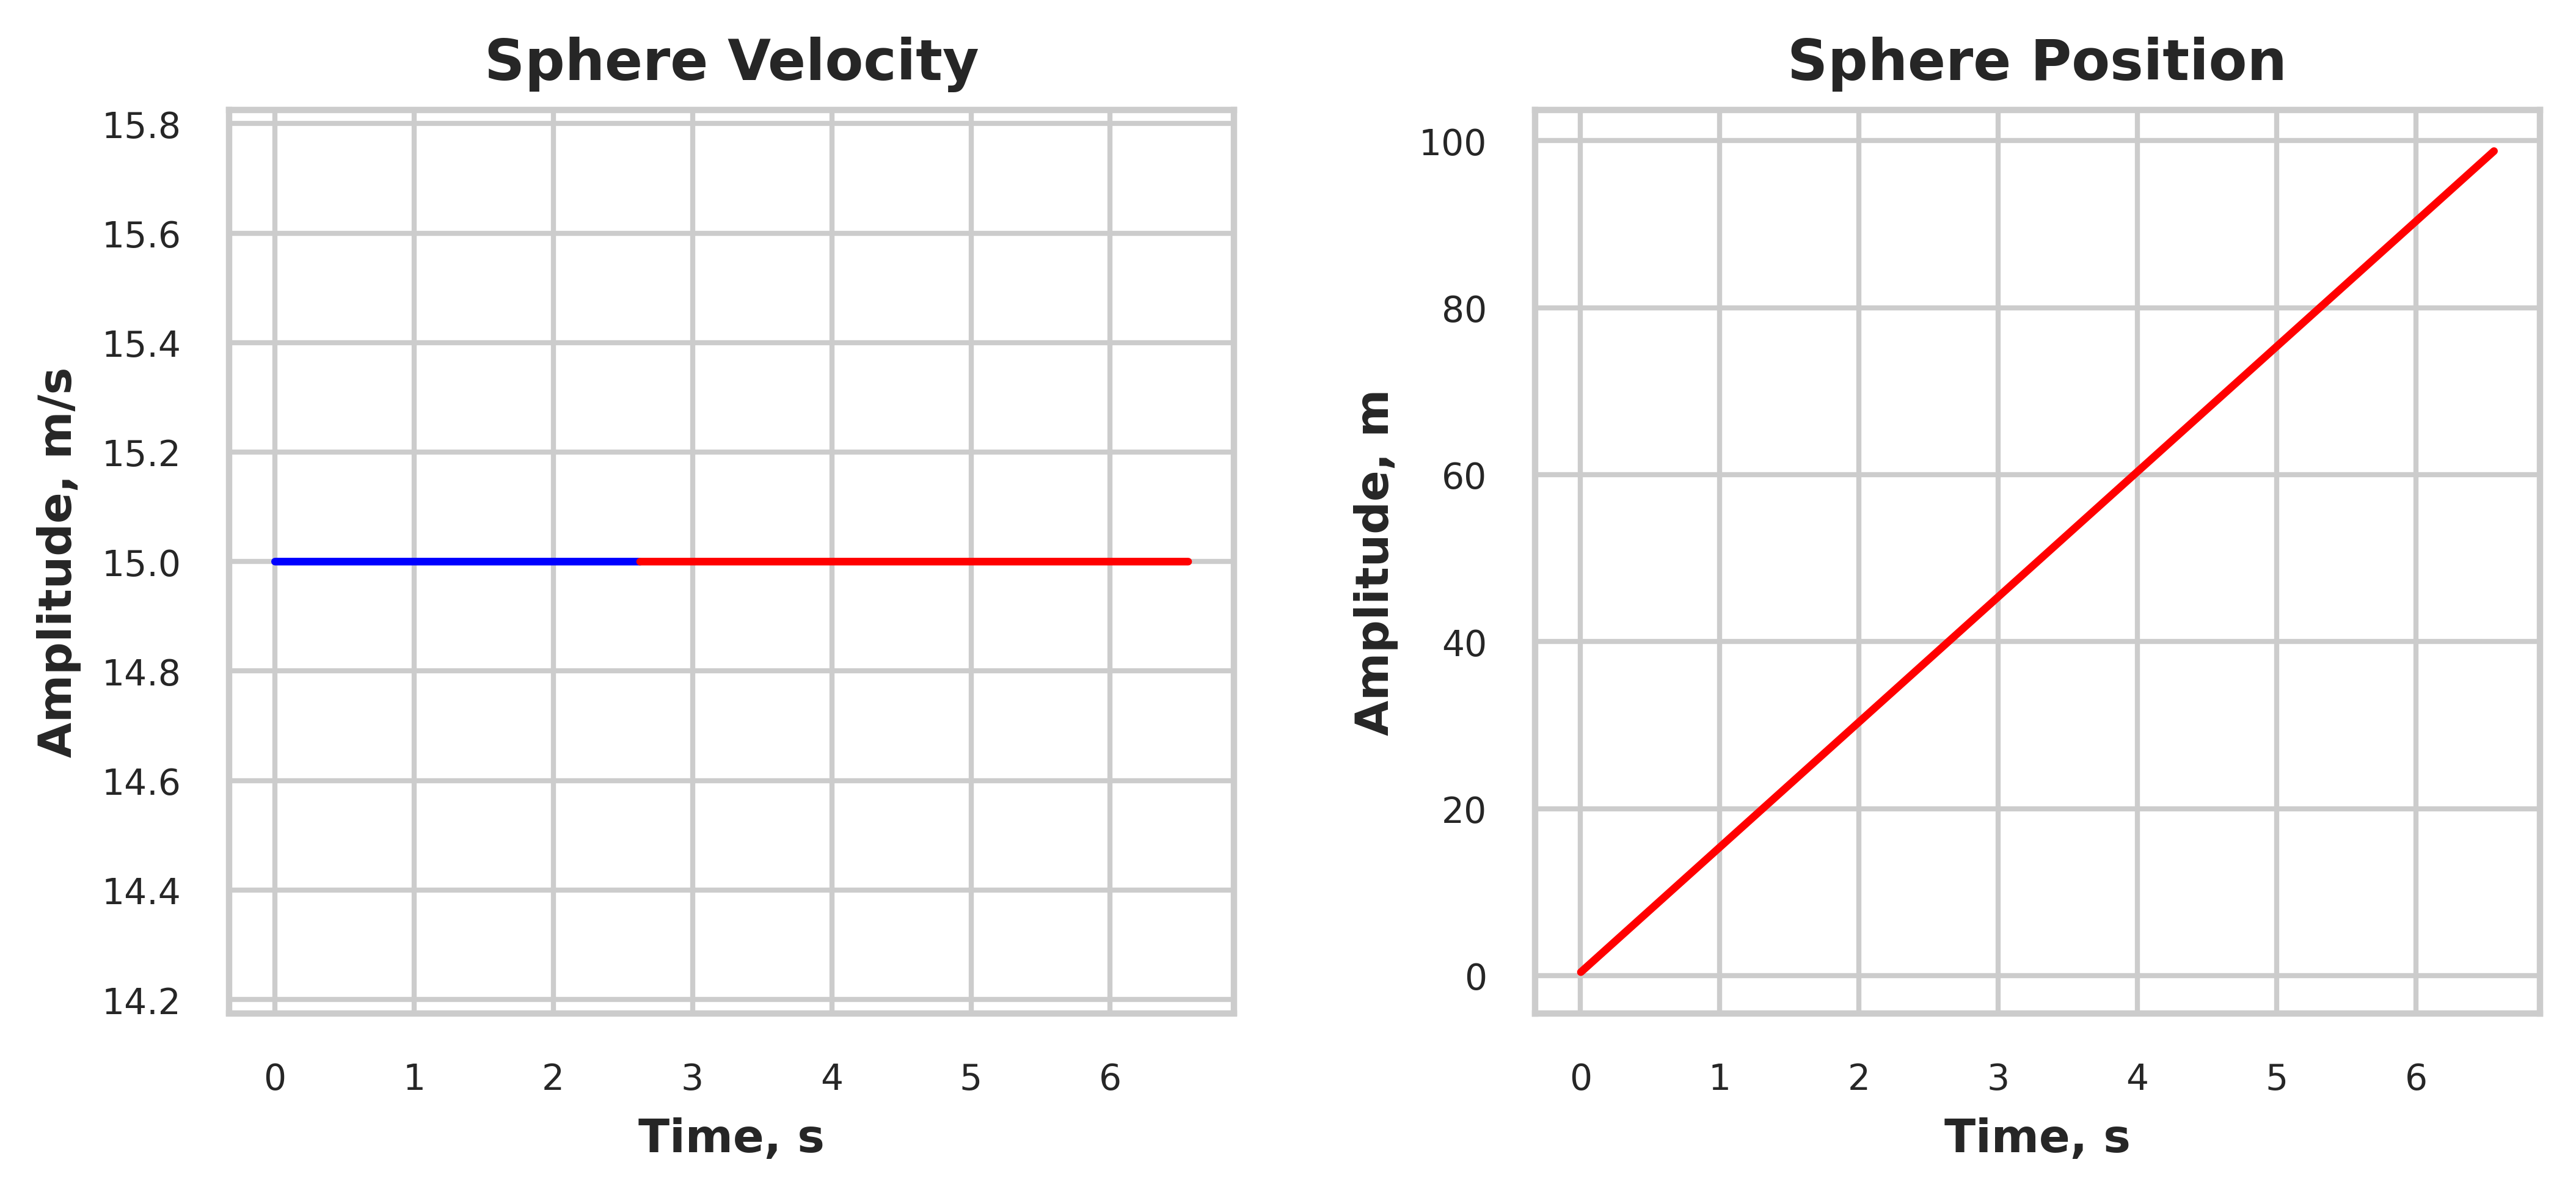

In [18]:
figsize = (width / dpi + 6, height / dpi + 2)
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi, sharex=False)
fig.subplots_adjust(wspace=0.3)

sns.lineplot(x=timevals_before, y=velocity_before, ax=ax[0], color="blue")
sns.lineplot(x=timevals_after, y=velocity_after, ax=ax[0], color="red")
ax[0].set_title('Sphere Velocity', weight="bold", fontsize=11)
ax[0].set_ylabel('Amplitude, m/s', weight="bold", fontsize=9)
ax[0].set_xlabel('Time, s', weight="bold", fontsize=9)
ax[0].tick_params(labelsize=7)

sns.lineplot(x=timevals_p, y=position, ax=ax[1], color="red")
ax[1].set_title('Sphere Position', weight="bold", fontsize=11)
ax[1].set_ylabel('Amplitude, m', weight="bold", fontsize=9)
ax[1].set_xlabel('Time, s', weight="bold", fontsize=9)
ax[1].tick_params(labelsize=7)

plt.savefig(f"../../output/newton_law_1.png", bbox_inches='tight')